# Exploratory Data Analysis - 311 Data
1. Ten Most Common Service Requests -
2. Busiest Divisions -
3. Distribution of Calls vs. Open311 App vs. Self Service (SS) reporting on the web -
4. How many days does it take to close a case? -
5. Average Number of Days Cases Are Open - Per Division -
6. Divisions with the largest change in volume or number of days open from 2016 to 2017
7. Complaint Reasons with the Greatest Change in Volume from 2016 to 2017
Busiest Months/Dates for opening cases and closing cases
8. Complaint type volume per open date or per closed date 
9. Case types that collect location
10. Map distribution of cases (by type?)
11. How closely do case types correlate with weather features?
correlation matrix or heat, t-test (a couple cells more)
chi sq 


In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
import folium
from folium import plugins
import json
import geojson
from shapely.geometry import Point

import scipy.stats as stats

In [2]:
# Read the csv file of cleaned data.
df = pd.read_csv('311_clean.csv', index_col=[0,1], parse_dates = ['Date', 'closed_date', 'open_day'])
df.head()

status         closed_date  days_open           reason  \
Date       Time                                                               
2016-01-01 00:10:35       0 2016-01-02 12:03:41        2.0  Traffic Control   
           07:50:34       0 2016-01-02 09:08:54        2.0  Traffic Control   
           08:46:35       0 2016-02-08 11:28:20       39.0       Snow & Ice   
           09:35:17       0 2016-01-04 09:30:00        3.0  Traffic Control   
           10:00:34       0 2016-01-02 09:37:55        1.0  Traffic Control   

                                    subject                        title  \
Date       Time                                                            
2016-01-01 00:10:35  Vehicles and Commuting  Abandoned Vehicle - Open311   
           07:50:34  Vehicles and Commuting  Parking Violation - Open311   
           08:46:35               Sidewalks   Sidewalk Snow and Ice - SS   
           09:35:17  Vehicles and Commuting  Parking Violation Complaint   
           10:00:34  Vehicles and Commuting  Parking Violation - Open311   

                     object_id       x_coord       y_coord     x_geom  \
Date       Time                                                         
2016-01-01 00:10:35       2196 -1.038160e+07  5.613667e+06 -93.259481   
           07:50:34      29550 -1.038520e+07  5.616158e+06 -93.291802   
           08:46:35      19633 -1.037889e+07  5.625311e+06 -93.235196   
           09:35:17      19634 -1.038501e+07  5.604598e+06 -93.290172   
           10:00:34       2197 -1.038350e+07  5.615948e+06 -93.276582   

                        ...      opened_month   open_day  open_time  \
Date       Time         ...                                           
2016-01-01 00:10:35     ...                 1 2016-01-01   00:10:35   
           07:50:34     ...                 1 2016-01-01   07:50:34   
           08:46:35     ...                 1 2016-01-01   08:46:35   
           09:35:17     ...                 1 2016-01-01   09:35:17   
           10:00:34     ...                 1 2016-01-01   10:00:34   

                    closed_year closed_month  max_temp  min_temp  \
Date       Time                                                    
2016-01-01 00:10:35      2016.0          1.0        30        15   
           07:50:34      2016.0          1.0        30        15   
           08:46:35      2016.0          2.0        30        15   
           09:35:17      2016.0          1.0        30        15   
           10:00:34      2016.0          1.0        30        15   

                     precipitation   snow  snow_depth  
Date       Time                                        
2016-01-01 00:10:35          0.005  0.005         4.0  
           07:50:34          0.005  0.005         4.0  
           08:46:35          0.005  0.005         4.0  
           09:35:17          0.005  0.005         4.0  
           10:00:34          0.005  0.005         4.0  

[5 rows x 22 columns]

## Ten Most Common Service Requests
The following are the most **common requests**
- Abandoned Vehicle
- Parking Violiation
- Exterior Nuisance Complaint
- Animal Complaint - Livability
- Graffiti complaint / reporting



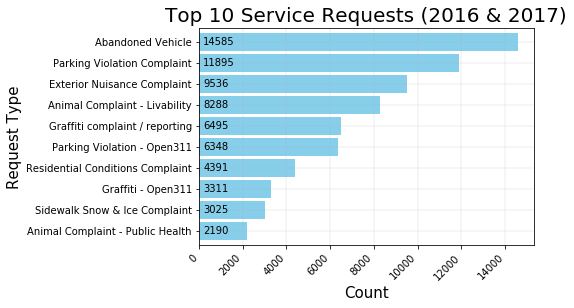

In [3]:
# Plot top 10 complaints by title
top_titles = df.groupby('title')['title'].count().sort_values(
                        ascending=False).head(10).sort_values()
_ = top_titles.plot.barh(color="skyblue", width = .85)

# Include numeric counts on each bar
for i, v in enumerate(top_titles):
    plt.text(200, i, str(v), va = 'center', color='black') #, fontweight='bold')

_ = plt.title('Top 10 Service Requests (2016 & 2017)', fontsize=20)
_ = plt.xlabel('Count', fontsize=15)
_ = plt.ylabel('Request Type', fontsize=15)
_ = plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
_ = plt.grid(linewidth=.2)
plt.show()

## Busiest Departments
The following are the most **active departments**
- Vehicles and Commuting
- Property
- Streets
- Public Safety
- Animal Related
- Sidewalks

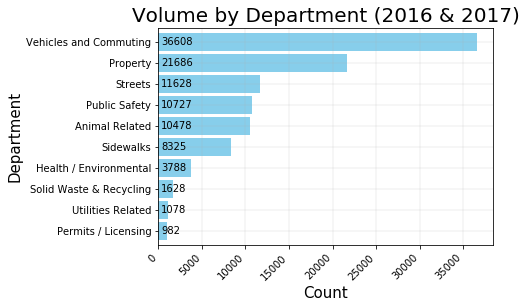

In [4]:
# Plot top 10 complaints by subject
top_depts = df.groupby('subject')['subject'].count().sort_values(
                        ascending=False).head(10).sort_values()
_ = top_depts.plot.barh(color= "skyblue", width = .85)

# Include numeric counts on each bar
for i, v in enumerate(top_depts):
    plt.text(300, i, str(v), va = 'center', color='black')

_ = plt.title('Volume by Department (2016 & 2017)', fontsize=20)
_ = plt.xlabel('Count', fontsize=15)
_ = plt.ylabel('Department', fontsize=15)
_ = plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
_ = plt.grid(linewidth=.2)
plt.show()

## Complaints By Reporting Platform (Phone, App, Online)
Complaints can be reported via 3 platforms: Calls, Open311 App, and Self Service (SS) online.  
*(Stacked graph by platform by month)*

- **App Reporting is Effective in Reducing Phone Staff** by including high volume topics that don't require immediate service.
- **Website Use Followed Overall Volume Patterns** with Exterior Nuisance complaints in the summer and Sidewalk Snow and Ice complaints in the winter. However, the summer of 2017 saw lower than usual website traffic. 

In [5]:
#Divide calls by reporting platform (Phone, App, Web)
open311_app = df[df.title.str.contains("Open311")]
ss_web = df[df.title.str.contains("- SS") | df.title.str.contains("- Self")]
phone = df[~df.title.str.contains("- SS") & ~df.title.str.contains("- Self") & ~df.title.str.contains("Open311")]

#ss_web.title.value_counts()
# 'Sidewalk Snow and Ice', 'Exterior Nuisance Complaint', 'Unpermitted Work' 
#open311_app.title.value_counts()

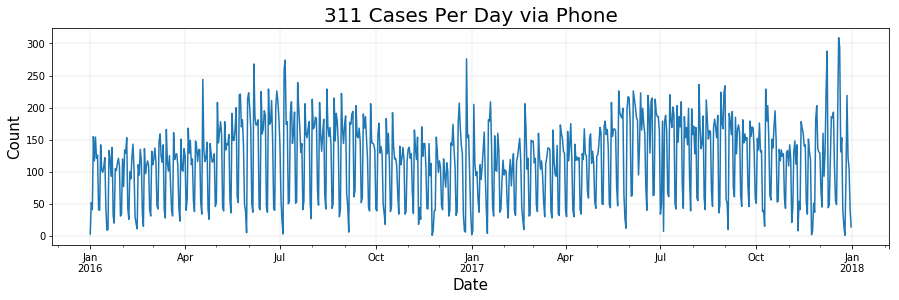

In [6]:
# Time series for requests received via phone.
phone.groupby('Date')['subject'].count().plot(figsize = (15,4))

plt.title('311 Cases Per Day via Phone', fontsize=20)
plt.ylabel('Count', fontsize = 15)
plt.xlabel('Date', fontsize = 15)
plt.grid(linewidth=.2)
plt.show()

### App Reporting is Effective in Reducing Phone Staffing
The top 4 App-reported complaints are among the highest volume topics overall. Furthermore, around 1/3 of the Parking Violations and Graffiti complaints are reported through the 311 app. 

With an eye to reducing phone staff, the App topics were well chosen. All are high volume service drivers, while none require immediate assistance (as Animal Related complaints might). This seems to be an efficient use of technology.

In [7]:
open311_app.title.value_counts().head(10)

Parking Violation - Open311                 6348
Graffiti - Open311                          3311
Abandoned Vehicle - Open311                 2003
Sidewalk Snow Ice - Open311                 1340
Street Light Trouble - Open311              1150
Pothole - Open311                           1104
Sidewalk Structural - Open311                840
Traffic Signal Trouble - Open311             456
Traffic Sign Repair - Open311                425
Solid Waste Overflowing Litter - Open311     360
Name: title, dtype: int64

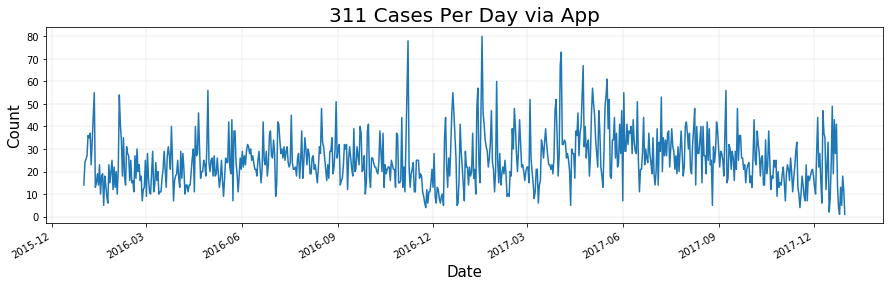

In [8]:
# Time series for requests received via open311_app.

open311_app.groupby('Date')['subject'].count().plot(figsize = (15,4))
plt.title('311 Cases Per Day via App', fontsize=20)
plt.ylabel('Count', fontsize = 15)
plt.xlabel('Date', fontsize = 15)
plt.grid(linewidth=.2)
plt.show()

### Website Use Follows Typical Volume Patterns for Exterior Nuisance and Sidewalk Snow and Ice complaints
Complaints reported on the website's Self-Service portal show sudden peaks December - February which are consistent with Sidewalk Snow and Ice accumulation.  

Throughout the summer months, Exterior Nuisance complaints increase. Once the snow melts, temperature rise, and students are out of school, it's time to enjoy being outside. Although noise complaints were reported on the website during the summer of 2016, far fewer were reported in 2017.

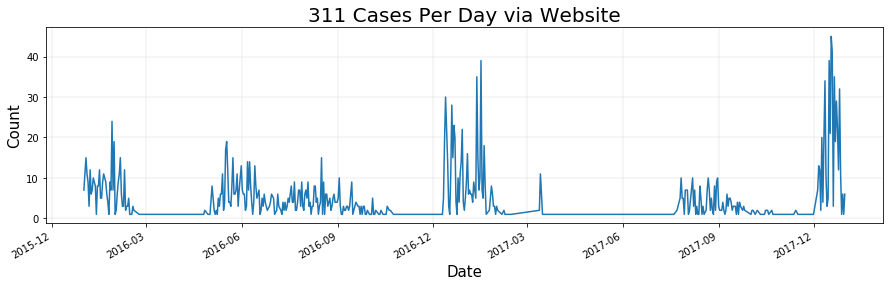

In [9]:
# Time series for requests received via web (Self-Service).
ss_web.groupby('Date')['subject'].count().plot(figsize = (15,4))

plt.title('311 Cases Per Day via Website', fontsize=20)
plt.ylabel('Count', fontsize = 15)
plt.xlabel('Date', fontsize = 15)
plt.grid(linewidth=.2)
plt.show()

#### Sidewalk complaints reported on the website peak dramatically in the snowy, winter months (Dec - Feb).


#### In the summer, website complaints are driven by exterior nuisance reports. 
Children are out of school during these months, and the warmer weather finally allows everyone to enjoy evenings outside. Although noise complaints were higher overall in both year from May - Sept, they were not reported online in 2017 until mid-July.

In [10]:
#Isolate phone calls that correspond to topics reported on the web.
web_as_calls = phone[(phone.title.str.contains("Sidewalk Snow") 
                      | phone.title.str.contains("Exterior Nuisance Complaint") 
                      | phone.title.str.contains("Unpermitted Work"))]

#web_as_calls = phone[(phone.title.str.contains("Sidewalk Snow") | phone.title.str.contains("Exterior Nuisance Complaint") | phone.title.str.contains("Unpermitted Work")) & ~phone.title.str.contains("RHOD")]

print('Web: ', ss_web.title.value_counts(), '\n')
print('Phone: ', web_as_calls.title.value_counts())


Web:  Sidewalk Snow and Ice - SS          1333
Exterior Nuisance - Self Service     971
Unpermitted Work - Self Service       42
Name: title, dtype: int64 

Phone:  Exterior Nuisance Complaint         9536
Sidewalk Snow & Ice Complaint       3025
Unpermitted Work                     682
RHOD Exterior Nuisance Complaint     595
Name: title, dtype: int64


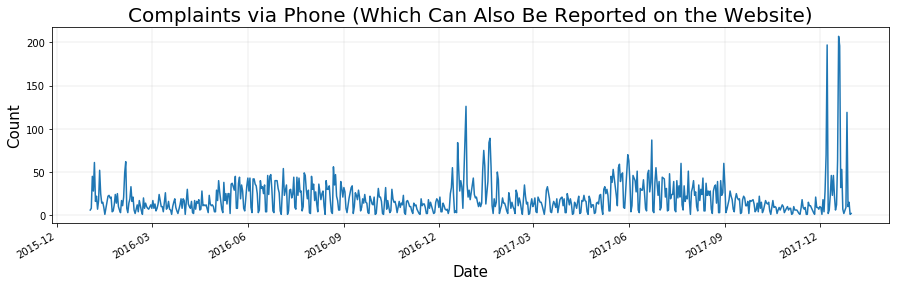

In [11]:
# Time series for phoned complaints also reported via the web (Self-Service).

web_as_calls.groupby('Date')['subject'].count().plot(figsize = (15,4))
plt.title('Complaints via Phone (Which Can Also Be Reported on the Website)', fontsize=20)
plt.ylabel('Count', fontsize = 15)
plt.xlabel('Date', fontsize = 15)
plt.grid(linewidth=.2)
plt.show()


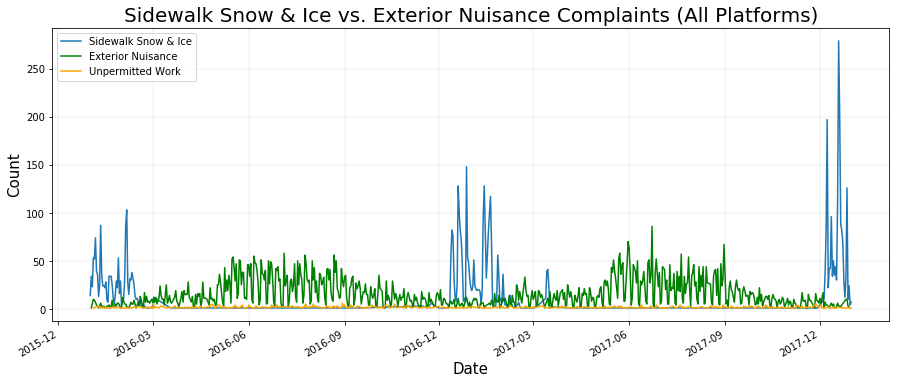

In [12]:
# Plot Sidewalk Snow & Ice complaints
sidewalk_ice = df[df.title.str.contains("Sidewalk Snow")]
sidewalk_ice.groupby('Date')['subject'].count().plot(
    figsize = (15,6), label = 'Sidewalk Snow & Ice')

# Plot Exterior Nuisance complaints
ext_nuisance = df[df.title.str.contains("Exterior Nuisance")]
ext_nuisance.groupby('Date')['subject'].count().plot(
    figsize = (15,6), color = 'g', label = 'Exterior Nuisance')

unpermitted_work = df[df.title.str.contains("Unpermitted Work")]
unpermitted_work.groupby('Date')['subject'].count().plot(
    figsize = (15,6), color = 'orange', label = 'Unpermitted Work')

plt.legend()
plt.title('Sidewalk Snow & Ice vs. Exterior Nuisance Complaints (All Platforms)', fontsize=20)
plt.ylabel('Count', fontsize = 15)
plt.xlabel('Date', fontsize = 15)
plt.grid(linewidth=.2)
plt.show()

In [13]:
df_weather = pd.read_csv("weather_clean.csv", index_col = 'Date', parse_dates = True)
df_weather.head()

,max_temp,min_temp,precipitation,snow,snow_depth
Date,,,,,
2016-01-01,30,15,0.005,0.005,4.0
2016-01-02,31,14,0.000,0.000,4.0
2016-01-03,29,20,0.000,0.000,4.0
2016-01-04,26,10,0.000,0.000,4.0
2016-01-05,32,20,0.000,0.000,4.0


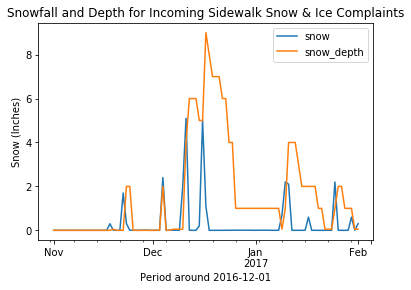

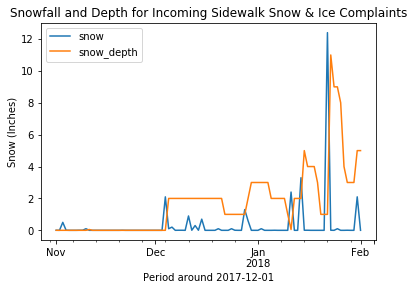

In [14]:
# Plotting snowfall and snow depth around the dates Sidewalk Snow & Ice Complaints spike.
#fig, ax = plt.subplots(1,2)
#plt.title('Snowfall and Depth During Resolution of Sidewalk Snow & Ice Complaints')

# Plot for 2017-03-31 timeframe
weather_march17 = df_weather.loc['2016-11-01':'2017-02-01', ['snow', 'snow_depth']]

#plt.subplot(1, 2, 1)
weather_march17.plot()
#plt.axvline(x='2017-03-31', color = 'grey')
plt.xlabel('Period around 2016-12-01')
plt.ylabel('Snow (Inches)')
plt.title('Snowfall and Depth for Incoming Sidewalk Snow & Ice Complaints')

# Plot for 2018-01-29 timeframe
weather_jan18 = df_weather.loc['2017-11-01':'2018-02-01', ['snow', 'snow_depth']]

#plt.subplot(1, 2, 2)
weather_jan18.plot()
plt.xlabel('Period around 2017-12-01')
plt.ylabel('Snow (Inches)')
#plt.axvline(x='2018-01-29', color = 'grey')
plt.title('Snowfall and Depth for Incoming Sidewalk Snow & Ice Complaints')

#plt.tight_layout()
plt.show()

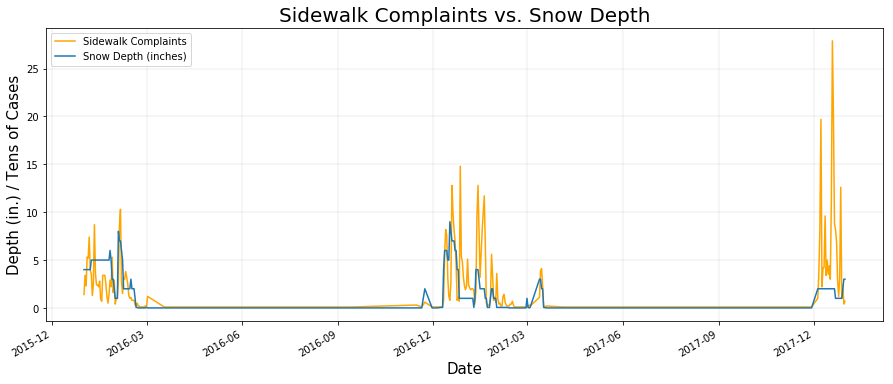

In [15]:
# Plotting snow depth vs Sidewalk Snow & Ice Complaints.

sidewalk_ice = df[df.title.str.contains("Sidewalk Snow")].groupby('Date')['subject'].count()
sidewalk_scaled = sidewalk_ice/10
sidewalk_scaled.plot(figsize = (15,6), color = 'orange', label = 'Sidewalk Complaints')

depth = df[df.title.str.contains("Sidewalk Snow")].groupby('Date')['snow_depth'].mean()
depth.plot(figsize = (15,6), label = 'Snow Depth (inches)')

plt.legend()
plt.title('Sidewalk Complaints vs. Snow Depth', fontsize=20)
plt.ylabel('Depth (in.) / Tens of Cases', fontsize = 15)
plt.xlabel('Date', fontsize = 15)
plt.grid(linewidth=.2)
plt.show()

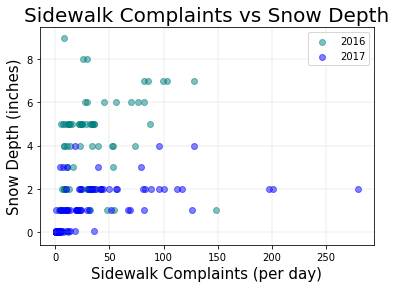

In [16]:
sidewalk_ice_16 = sidewalk_ice.loc['2016']
depth_16 = depth.loc['2016']

sidewalk_ice_17 = sidewalk_ice.loc['2017']
depth_17 = depth.loc['2017']

plt.scatter(sidewalk_ice_16, depth_16, label= '2016', color = 'teal', alpha = .5)
plt.scatter(sidewalk_ice_17, depth_17, label= '2017', color = 'blue', alpha = .5)

#plt.scatter(depth, sidewalk_ice, color = 'blue')
plt.title('Sidewalk Complaints vs Snow Depth', fontsize=20)
plt.xlabel('Sidewalk Complaints (per day)', fontsize = 15)
plt.ylabel('Snow Depth (inches)', fontsize = 15)
plt.legend()
plt.grid(linewidth=.2)
plt.show()

In [17]:
s16m = sidewalk_ice.loc['2016-12'].mean()
d16m = depth.loc['2016-12'].mean()

s17m = sidewalk_ice.loc['2017-12'].mean()
d17m = depth.loc['2017-12'].mean()

print('2016 Average daily complaints: ', s16m, " (max of", sidewalk_ice.loc['2016-12'].max(), ")")
print('2016 Average snow depth: ', d16m)
print('2017 Average daily complaints: ', s17m, " (max of", sidewalk_ice.loc['2017-12'].max(), ")")
print('2017 Average snow depth: ', d17m)

2016 Average daily complaints:  42.36  (max of 148 )
2016 Average snow depth:  3.846
2017 Average daily complaints:  66.51851851851852  (max of 279 )
2017 Average snow depth:  1.8148148148148149


#### Sidewalk Snow and Ice complaints correlate with Snow Depth
When it snows, residents have 24 hours to clear sidewalks of snow. Apartment and commercial buildings have 4 daylight hours to clear them. Sidewalks that aren't passable can be reported to the City. The problematic sidewalks are inspected, and residents or building owners can be fined for failure to clear them. It make sense that Sidewalk complaints would occur then snow has accumulated, that correlation isn't surprising. 

#### What's notable is the increase in complaints from 2016 to 2017. 
Snow accumulated twice as high in 2016 than 2017. In the month of December, the average snow depth was 3.8 inches in 2016, and only 1.8 inches the next year. Despite less snow, complaints drastically increased. The City received an average of 42.36 complaints per day in 2016 and 67.52 in 2017. On one day alone, 279 complaints were reported.  

The lack of compliance with the shoveling ordinance has lead the City is looking at other options. In 2018-2019, they're considering having City crews plow all sidwalks. This would be very costly, but make the City more walkable and accessible.

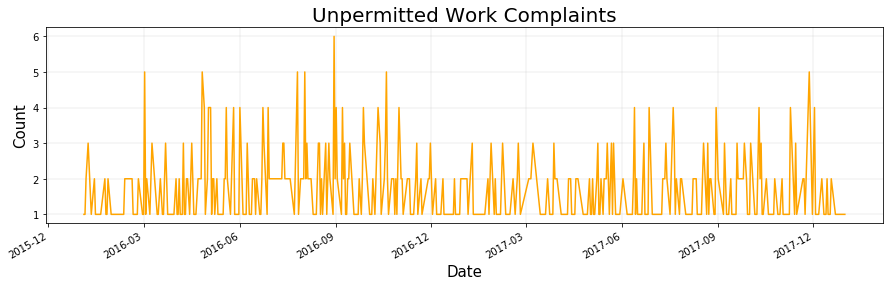

In [18]:
# Zoom in on Unpermitted Work complaints
unpermitted_work = df[df.title.str.contains("Unpermitted Work")]
unpermitted_work.groupby('Date')['subject'].count().plot(figsize = (15,4), color = 'orange')
plt.title('Unpermitted Work Complaints', fontsize=20)
plt.ylabel('Count', fontsize = 15)
plt.xlabel('Date', fontsize = 15)
plt.grid(linewidth=.2)
plt.show()

Unpermitted work complaints are steady and low through out the year. There was a slight rise in complaints for the second half of each year - May-Nov 2016, and June-Dec 2017.

## How Many Days Does Take to Close a Case?
On average, cases were closed within 3 days. Within 7 days (a week), 75% of cases were closed. That said, the distribution is skewed with many cases left open for over 100 days.

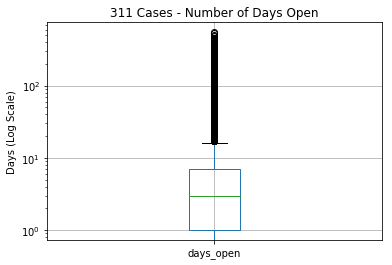

In [19]:
# View box plot of number of days open, to visually inspect outliers
df.boxplot(column='days_open')
plt.yscale('log')
plt.title('311 Cases - Number of Days Open')
plt.ylabel('Days (Log Scale)')
plt.show()

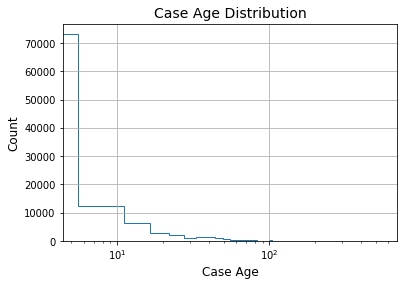

In [20]:
# plot days_open to see what the distribution looks like
_ = df['days_open'].hist(bins = 100, histtype = 'step')
plt.xlabel('Case Age', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Case Age Distribution', fontsize=14)
plt.xscale('log')
plt.show()

## Average Number of Days Cases Are Open - Per Division
* Every subject has a wide range of days until a case is closed. With data points **ranging from 1 to 550**, the y-axis was scaled with the log function. This makes higher data points more visible.
* The 25th to 75th percentile box for **Animal Related** cases lies entirely at 1 day. This subject has the most consistent close time, and has the 2nd shortest spread. **Permits/Licensing** has a slightly shorter overall spread, with a maximum of only 26 days to close a case. This may be due to department efficiencies, or that it has the lowest volume of requests.
* **Public Safety** complaints stay open the longest on average, at 11 days.
* There aren't visually apparent patterns correlating mean, spread, and density. 

In [21]:
df.describe()

,status,days_open,object_id,x_coord,y_coord,x_geom,y_geom,opened_year,opened_month,closed_year,closed_month,max_temp,min_temp,precipitation,snow,snow_depth
count,106928.000000,106325.000000,106928.000000,1.069280e+05,1.069280e+05,1.069280e+05,1.069280e+05,106928.000000,106928.000000,106325.000000,106325.000000,106928.000000,106928.000000,106928.000000,106928.000000,106928.000000
mean,0.005639,11.259149,26759.527533,-9.607225e+06,5.196746e+06,-8.630317e+01,4.160782e+01,2016.515889,6.639692,2016.552523,6.492462,60.202660,43.410267,0.106029,0.063588,0.527504
std,0.074884,31.301559,15480.518465,2.729446e+06,1.476424e+06,2.451903e+01,1.182098e+01,0.499750,3.273724,0.548467,3.279049,22.375392,20.303351,0.287227,0.422753,1.415929
min,0.000000,0.000000,1.000000,-1.038935e+07,0.000000e+00,-9.332915e+01,-1.280796e-14,2016.000000,1.000000,2016.000000,1.000000,-6.000000,-20.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,13366.750000,-1.038512e+07,5.610720e+06,-9.329116e+01,4.493135e+01,2016.000000,4.000000,2016.000000,4.000000,41.000000,29.000000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,26732.500000,-1.038250e+07,5.614949e+06,-9.326761e+01,4.495823e+01,2017.000000,7.000000,2017.000000,7.000000,66.000000,47.000000,0.000000,0.000000,0.000000
75%,0.000000,7.000000,40098.250000,-1.037922e+07,5.620285e+06,-9.323808e+01,4.499214e+01,2017.000000,9.000000,2017.000000,9.000000,79.000000,61.000000,0.040000,0.000000,0.000000
max,1.000000,550.000000,55164.000000,0.000000e+00,5.629593e+06,2.544444e-14,4.505124e+01,2017.000000,12.000000,2018.000000,12.000000,97.000000,77.000000,2.180000,8.800000,9.000000


In [22]:
df.groupby('subject')['days_open'].describe()

,count,mean,std,min,25%,50%,75%,max
subject,,,,,,,,
Animal Related,10478.0,1.571769,2.655160,1.0,1.0,1.0,1.0,59.0
Health / Environmental,3771.0,12.918324,40.890281,1.0,1.0,2.0,4.0,420.0
Permits / Licensing,982.0,3.393075,3.314976,1.0,1.0,2.0,5.0,26.0
Property,21276.0,25.179921,57.297202,1.0,3.0,6.0,16.0,550.0
Public Safety,10643.0,16.738701,22.017228,1.0,2.0,11.0,21.0,254.0
Sidewalks,8325.0,19.487087,24.328571,1.0,2.0,8.0,38.0,290.0
Solid Waste & Recycling,1628.0,4.275184,11.595697,1.0,1.0,2.0,4.0,274.0
Streets,11543.0,10.641514,23.940677,1.0,2.0,4.0,9.0,534.0
Utilities Related,1078.0,6.163265,9.479552,1.0,1.0,3.0,8.0,157.0


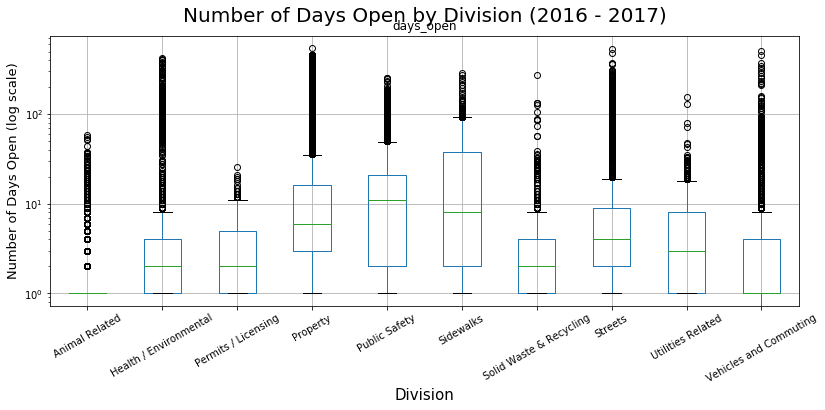

In [23]:
# Visualize boxplots, by subject, of number of days each case is open.
fig, ax = plt.subplots(figsize=(13,5))
#plt.suptitle('Number of Days Open by Division (2016 - 2017)', fontsize=20)
df.boxplot(column=['days_open'], by='subject', ax=ax, rot=30)
plt.yscale('log')
#plt.title('Number of Days Open by Division (2016 - 2017)', fontsize=20)
plt.xlabel('Division', fontsize=15)
plt.ylabel('Number of Days Open (log scale)', fontsize=13)
#plt.title('Number of Days Open by Division', fontsize=20)
plt.suptitle('Number of Days Open by Division (2016 - 2017)', fontsize=20)

plt.show()

## A large group of calls were closed on 2018-01-29, 2017-03-31

### Residential Conditions Complaints 
A cluster of more than 250 Residential Conditions Complaints were all closed at the end of October, 2017. Identical x- y- coordinates indicate they were complaints about the same building.

In [24]:
top_close = df.closed_date.value_counts(dropna=False)[:11]
top_close

NaT                    603
2018-01-29 07:41:25    100
2018-01-29 07:39:05    100
2017-03-31 08:45:18     95
2018-01-29 07:36:39     95
2018-01-29 08:26:09     91
2017-03-31 13:45:55     91
2017-10-31 12:34:48     84
2017-03-31 13:47:49     68
2018-01-29 07:46:29     64
2018-01-29 08:27:21     63
Name: closed_date, dtype: int64

In [25]:
for index in top_close.index:
    reason = df.loc[df.closed_date == index].reason.value_counts()
    print(index, ": ", reason)

NaT :  Series([], Name: reason, dtype: int64)
2018-01-29 07:41:25 :  Snow & Ice    100
Name: reason, dtype: int64
2018-01-29 07:39:05 :  Snow & Ice    100
Name: reason, dtype: int64
2017-03-31 08:45:18 :  Snow & Ice    95
Name: reason, dtype: int64
2018-01-29 07:36:39 :  Snow & Ice    95
Name: reason, dtype: int64
2018-01-29 08:26:09 :  Snow & Ice    91
Name: reason, dtype: int64
2017-03-31 13:45:55 :  Snow & Ice    91
Name: reason, dtype: int64
2017-10-31 12:34:48 :  Private Property    84
Name: reason, dtype: int64
2017-03-31 13:47:49 :  Snow & Ice    68
Name: reason, dtype: int64
2018-01-29 07:46:29 :  Snow & Ice    64
Name: reason, dtype: int64
2018-01-29 08:27:21 :  Snow & Ice    63
Name: reason, dtype: int64


In [26]:
#df.loc[(df.closed_date == '2017-10-31 12:34:48') & (df.title == 'Residential Conditions Complaint')][].head()

res_cluster = df.loc[(df.closed_year == 2017) & (df.closed_month == 10.0) & 
                     (df.title == 'Residential Conditions Complaint')][
                      ['closed_date', 'object_id', 'x_coord', 'y_coord', 'x_geom', 'y_geom']]

res_cluster.tail()

closed_date  object_id  x_coord  y_coord  \
Date       Time                                                        
2017-10-27 06:49:12 2017-10-31 03:23:22      50461      0.0      0.0   
           09:51:52 2017-10-30 03:41:19       3972      0.0      0.0   
2017-10-28 11:16:36 2017-10-30 10:35:04       6267      0.0      0.0   
2017-10-30 11:00:28 2017-10-31 03:46:25       6319      0.0      0.0   
2017-10-31 04:55:56 2017-10-31 06:58:38      46588      0.0      0.0   

                           x_geom        y_geom  
Date       Time                                  
2017-10-27 06:49:12  2.544444e-14 -1.280796e-14  
           09:51:52  2.544444e-14 -1.280796e-14  
2017-10-28 11:16:36  2.544444e-14 -1.280796e-14  
2017-10-30 11:00:28  2.544444e-14 -1.280796e-14  
2017-10-31 04:55:56  2.544444e-14 -1.280796e-14

In [27]:
res_cluster.x_coord.value_counts()

0.0    266
Name: x_coord, dtype: int64

In [28]:
res_cluster.x_geom.value_counts()

2.544444e-14    254
0.000000e+00     12
Name: x_geom, dtype: int64

## Divisions with the largest change in volume or number of days open from 2016 to 2017

* From 2016 to 2017, **Vehicles and Communiting, Streets, Solid Waste & Recycling, Permits / Licensing**, and **Animal Related** cases all had **minimal change** in the amount of time it took to close cases. The mean close time differed by less than 1 day.
* At the other end of the spectrum, **Property** or **Health / Environmental** cases increased by slightly over **20 days**. 

In [29]:
subj_mean16 = df.loc['2016'].groupby('subject')['days_open'].mean()
subj_mean17 = df.loc['2017'].groupby('subject')['days_open'].mean()
subj_diff = subj_mean17 - subj_mean16
subj_diff.sort_values(ascending=False)

subject
Property                   20.652863
Health / Environmental     20.454866
Sidewalks                   4.760851
Public Safety               3.125073
Permits / Licensing         0.948934
Animal Related             -0.156991
Vehicles and Commuting     -0.204341
Solid Waste & Recycling    -0.484780
Streets                    -0.683370
Utilities Related          -2.408533
Name: days_open, dtype: float64

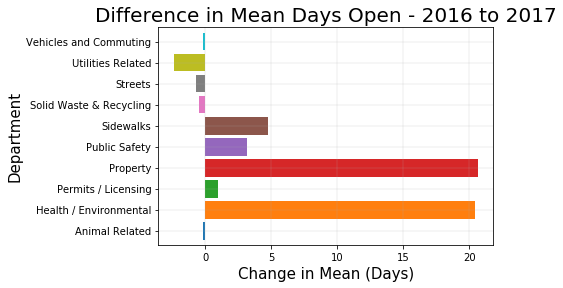

In [30]:
# Plot change from 2016 to 2017 for number of days cases are were open.
_= subj_diff.plot(kind = 'barh', width = .85)
#_ = top_depts.plot.barh(color= "skyblue", width = .85)

# Include numeric counts on each bar
#for i, v in enumerate(top_depts):
#    plt.text(300, i, str(v), va = 'center', color='black')

_ = plt.title('Difference in Mean Days Open - 2016 to 2017', fontsize=20)
_ = plt.xlabel('Change in Mean (Days)', fontsize=15)
_ = plt.ylabel('Department', fontsize=15)
_ = plt.grid(linewidth=.2)
plt.show()

### Property cases - What's driving the increase in average number of days these cases are open?
We will break these cases down into Reason and Title sub-categories. To identify the main drivers, we'll examine the number of cases and the average days open per sub-category.

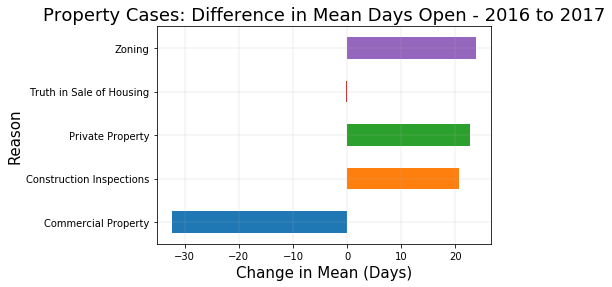

In [31]:
property_mean16 = df[df['subject']=='Property'].loc['2016'].groupby('reason')['days_open'].mean()
property_mean17 = df[df['subject']=='Property'].loc['2017'].groupby('reason')['days_open'].mean()
property_diff =  property_mean17 - property_mean16
property_diff.plot(kind = 'barh')

_ = plt.title('Property Cases: Difference in Mean Days Open - 2016 to 2017', fontsize=18)
_ = plt.xlabel('Change in Mean (Days)', fontsize=15)
_ = plt.ylabel('Reason', fontsize=15)
_ = plt.grid(linewidth=.2)
plt.show()


#### Commercial property cases too 30 days less to closed in 2017. Most other case reasons took 20 days longer to close. 

We'll examine volume to see which reason type is driving the Property case metrics.

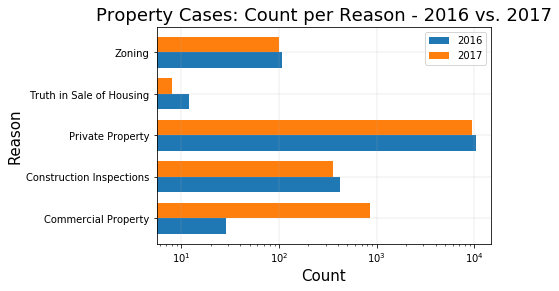

In [32]:
property_count16 = df[df['subject']=='Property'].loc['2016'].groupby('reason')['reason'].count()
property_count17 = df[df['subject']=='Property'].loc['2017'].groupby('reason')['reason'].count()
property_increase =  (property_count17 - property_count16)
property_1617= pd.concat([property_count16, property_count17], axis=1, sort=True)
property_1617.columns = ['2016', '2017']
property_1617.plot(kind = 'barh', width=.75)
plt.xscale('log') #View as log scale due to the number of Private Property cases.

_ = plt.title('Property Cases: Count per Reason - 2016 vs. 2017', fontsize=18)
_ = plt.xlabel('Count', fontsize=15)
_ = plt.ylabel('Reason', fontsize=15)
_ = plt.grid(linewidth=.2)
plt.show()

In [33]:
m= pd.concat([property_count16, property_count17, property_increase, property_mean16, property_mean17], axis=1, sort=True)
m.columns = ['2016_Count', '2017_Count', 'Difference', '2016_Mean', '2017_Mean']
m

,2016_Count,2017_Count,Difference,2016_Mean,2017_Mean
reason,,,,,
Commercial Property,29,861,832,48.344828,15.977673
Construction Inspections,426,360,-66,9.171362,29.823529
Private Property,10424,9358,-1066,15.493573,38.111595
Truth in Sale of Housing,12,8,-4,1.916667,1.750000
Zoning,107,101,-6,3.411215,27.227723


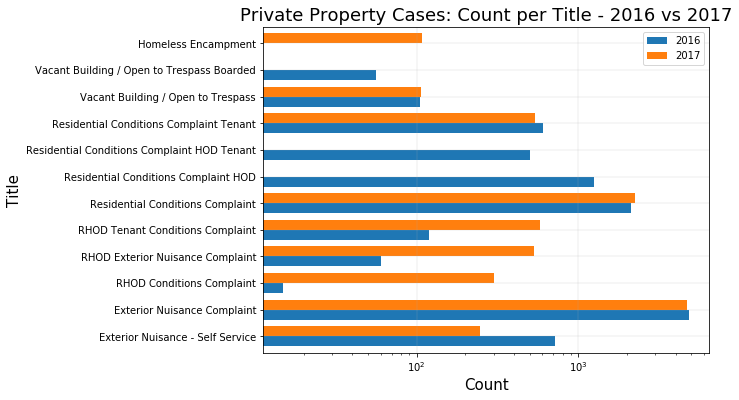

In [34]:
prop_title_mean16 = df[df['subject']=='Property'].loc['2016'].groupby('title')['days_open'].mean()
prop_title_mean17 = df[df['subject']=='Property'].loc['2017'].groupby('title')['days_open'].mean()
#prop_title_count16 = df[df['subject']=='Property'].loc['2016'].groupby('title')['reason'].count()
#prop_title_count17 = df[df['subject']=='Property'].loc['2017'].groupby('title')['reason'].count()

#Look only at driving reason type: Private Property
prop_title_count16 = df[df['reason']=='Private Property'].loc['2016'].groupby('title')['reason'].count()
prop_title_count17 = df[df['reason']=='Private Property'].loc['2017'].groupby('title')['reason'].count()
prop_title_increase =  (prop_title_count17 - prop_title_count16)
prop_title_1617= pd.concat([prop_title_count16, prop_title_count17], axis=1, sort=False)
prop_title_1617.columns = ['2016', '2017']


prop_title_1617.plot(kind = 'barh', figsize = (8,6), width = .75)
plt.xscale('log') #View as log scale due to the number of Exterior Nuisance cases.
_ = plt.title('Private Property Cases: Count per Title - 2016 vs 2017', fontsize=18)
_ = plt.xlabel('Count', fontsize=15)
_ = plt.ylabel('Title', fontsize=15)
_ = plt.grid(linewidth=.2)
plt.show()

In [35]:
t = pd.concat([prop_title_count16, prop_title_count17, prop_title_increase, prop_title_mean16, prop_title_mean17], axis=1, sort=False)
t.columns = ['2016_Count', '2017_Count', 'Difference', '2016_Mean', '2017_Mean']
#t

#### Private Property complaints make up 95% of Property cases in 2016 and 88% in 2017.

#### At the title levele, we see Exterior Nuisance complaints drive the entire category's increase in average days open.
There are over 10 times as many Private Property cases than any other Property sub-type. These cases overwhelmingly drive the Property group's metrics. Although the number of Private Property calls decrease by around 10% from 2016 to 2017, the average days open increase from 14.5 to 37.1 days.

## Complaint Reasons with the Most Change (Increase or Decrease)
**Most Increase in 2017**
- Commercial Property	  :  2868.97%
- Garbage & Recycling	  :  124.95%
- Graffiti / Clean City	  :  24.14%
- Parking	  :  23.80%
- Fire	  :  22.71%

**Most Decrease in 2017**
- Construction Inspections	  :  -15.49%
- Biking	  :  -26.43%
- Truth in Sale of Housing	  :  -33.33%
- Bridges	  :  -60.00%
- Inspection	  :  -77.37%

In [36]:
def ends(df, x=5):
    return df.head(x).append(df.tail(x))

In [37]:
reason_count16 = df.loc['2016'].groupby('reason')['reason'].count()
reason_count17 = df.loc['2017'].groupby('reason')['reason'].count()
reason_increase =  (reason_count17 - reason_count16)
reason_increase_pct = (reason_increase/reason_count16)*100
reason_1617= pd.concat([reason_count16, reason_count17, reason_increase, reason_increase_pct], 
                       axis=1)
reason_1617.columns = ['2016', '2017', 'Increase', 'Percent Increase']
reason_1617 = reason_1617.sort_values(by='Percent Increase', ascending = False)
reason_1617_ends = ends(reason_1617, 5)

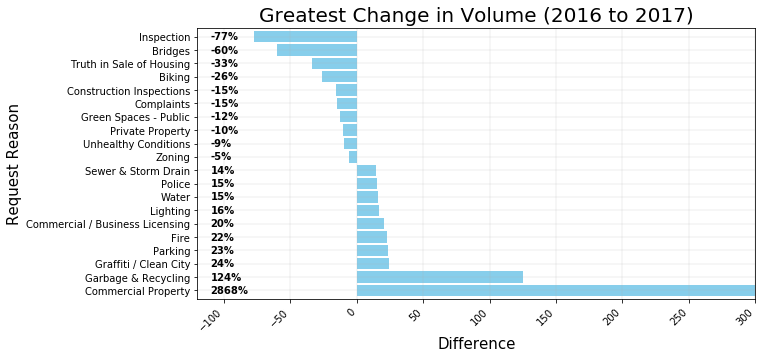

In [38]:
# Plot top and bottom 10 complaint Reasons with the greatest change in volume from 2016 to 2017

reason_1617_ends = ends(reason_1617, 10)

_ = reason_1617_ends['Percent Increase'].plot.barh(color="skyblue", 
                                                   width = .85, figsize = (10,5))

# Include numeric counts on each bar
for y, x in enumerate(reason_1617_ends['Percent Increase']):
    plt.text(-110, y, str(int(x)) + '%', va = 'center', color='black', fontweight='bold')

_ = plt.title('Greatest Change in Volume (2016 to 2017)', fontsize=20)
_ = plt.xlabel('Difference', fontsize=15)
_ = plt.ylabel('Request Reason', fontsize=15)
_ = plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
_ = plt.xlim([-120, 300])
_ = plt.grid(linewidth=.2)
plt.show()


In [39]:
# Why what there a 2869% increase in Commercial Property cases?
# Commercial/Mixed Conditions Complaints jumped

cp16 = df[df.reason == "Commercial Property"].loc['2016'].groupby('title')['reason'].count()
cp17 = df[df.reason == "Commercial Property"].loc['2017'].groupby('title')['reason'].count()
cp_diff =  (cp17 - cp16)
cp_1617= pd.concat([cp16, cp17, cp_diff], axis=1)
cp_1617.columns = ['2016', '2017', 'Difference']
cp_1617

,2016,2017,Difference
title,,,
Commercial Structure Unsound,5,2,-3
Commercial/Mixed Conditions Complaint,24,859,835


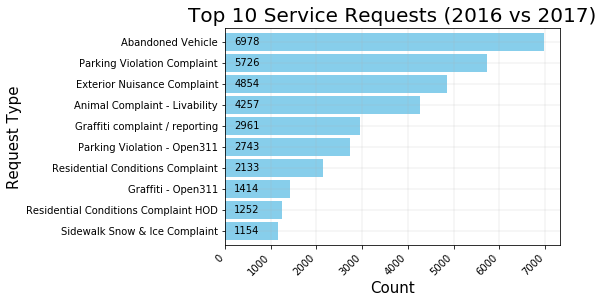

In [40]:
# Plot top 10 complaints by title BY YEAR
top_titles16 = df.loc['2016'].groupby('title')['title'].count().sort_values(
                        ascending=False).head(10).sort_values()
top_titles17 = df.loc['2017'].groupby('title')['title'].count().sort_values(
                        ascending=False).head(10).sort_values()
# Plot 2016
_ = top_titles16.plot.barh(color="skyblue", width = .85)

# Include numeric counts on each bar
for i, v in enumerate(top_titles16):
    plt.text(200, i, str(v), va = 'center', color='black') #, fontweight='bold')
    
# Plot 2017
#_ = top_titles17.plot.barh(color="steelblue", width = .85)

# Include numeric counts on each bar
#for i, v in enumerate(top_titles17):
#    plt.text(200, i, str(v), va = 'center', color='black') #, fontweight='bold')

_ = plt.title('Top 10 Service Requests (2016 vs 2017)', fontsize=20)
_ = plt.xlabel('Count', fontsize=15)
_ = plt.ylabel('Request Type', fontsize=15)
_ = plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
_ = plt.grid(linewidth=.2)
plt.show()

In [41]:
top = pd.concat([top_titles16, top_titles17], axis=1, sort= True)
top.columns = ['2016 Count', '2017 Count']
top = top.sort_values(by = '2016 Count', ascending=False)
top

,2016 Count,2017 Count
Abandoned Vehicle,6978.0,7607.0
Parking Violation Complaint,5726.0,6169.0
Exterior Nuisance Complaint,4854.0,4682.0
Animal Complaint - Livability,4257.0,4031.0
Graffiti complaint / reporting,2961.0,3534.0
Parking Violation - Open311,2743.0,3605.0
Residential Conditions Complaint,2133.0,2258.0
Graffiti - Open311,1414.0,1897.0
Residential Conditions Complaint HOD,1252.0,NaN
Sidewalk Snow & Ice Complaint,1154.0,1871.0


## Case volume and age per open date or per closed date

In [42]:
#df1 = df = pd.read_csv('311_clean.csv', index_col=[0,1], parse_dates = ['Date', 'closed_date', 'open_day'])
#df1.head()
months = [' ', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 
          'Sep', 'Oct', 'Nov', 'Dec']
df.columns

Index(['status', 'closed_date', 'days_open', 'reason', 'subject', 'title',
       'object_id', 'x_coord', 'y_coord', 'x_geom', 'y_geom', 'opened_year',
       'opened_month', 'open_day', 'open_time', 'closed_year', 'closed_month',
       'max_temp', 'min_temp', 'precipitation', 'snow', 'snow_depth'],
      dtype='object')

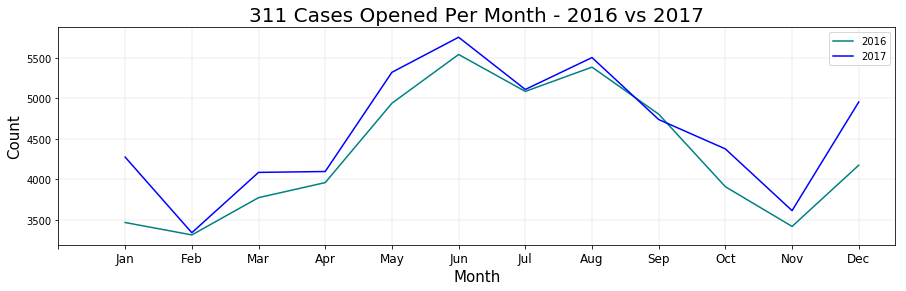

In [43]:
# Time series for 311 Cases Opened Per Month - 2016 vs 2017

df.loc['2016'].groupby('opened_month')['subject'].count().plot(figsize = (15,4), 
                                                               color = 'teal', label= '2016')
df.loc['2017'].groupby('opened_month')['subject'].count().plot(figsize = (15,4), 
                                                               color = 'blue', label= '2017')
plt.title('311 Cases Opened Per Month - 2016 vs 2017', fontsize=20)
plt.ylabel('Count', fontsize = 15)
plt.xlabel('Month', fontsize = 15)
plt.xticks(np.arange(13), months, 
           fontsize='12', horizontalalignment='center')
plt.legend()
plt.grid(linewidth=.2)
plt.show()

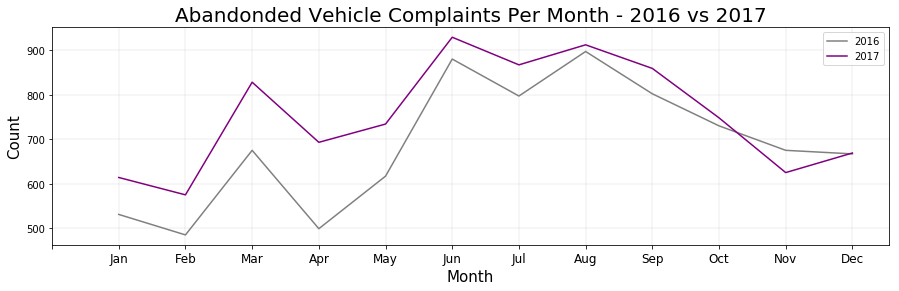

In [44]:
# Time series for largest volume driver, abandoned vehicles.

df[df['title'].str.contains('Abandoned')].loc['2016'].groupby('opened_month')['subject'].count().plot(
    figsize = (15,4), color = 'grey', label= '2016')
df[df['title'].str.contains('Abandoned')].loc['2017'].groupby('opened_month')['subject'].count().plot(
    figsize = (15,4), color = 'purple', label= '2017')

plt.title('Abandonded Vehicle Complaints Per Month - 2016 vs 2017', fontsize=20)
plt.ylabel('Count', fontsize = 15)
plt.xlabel('Month', fontsize = 15)
plt.xticks(np.arange(13), months, 
           fontsize='12', horizontalalignment='center')
plt.legend()
plt.grid(linewidth=.2)
plt.show()

### Busiest months for incoming complaints:
- **May - September ('16) or October ('17)**: Volume during the summer months is driven by the top complaint topics such as **Abandonded vehicles** and **Exterior nuisance** cases. The peak season lasted a month longer in 2017, and was slightly higher most months of the year.
- **December**: Another spike happens in December when snow accumulates and **Sidewalk Snow and Ice** complaints are reported.

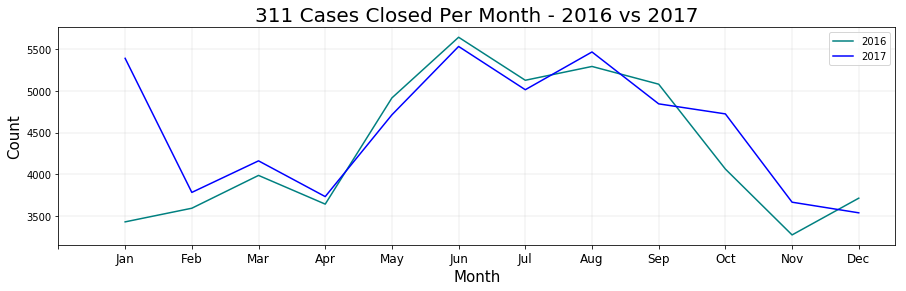

In [45]:
# Time series for 311 Cases Closed Per Month - 2016 vs 2017

df.loc['2016'].groupby('closed_month')['subject'].count().plot(figsize = (15,4), 
                                                               color = 'teal', label= '2016')
df.loc['2017'].groupby('closed_month')['subject'].count().plot(figsize = (15,4), 
                                                               color = 'blue', label= '2017')
plt.title('311 Cases Closed Per Month - 2016 vs 2017', fontsize=20)
plt.ylabel('Count', fontsize = 15)
plt.xlabel('Month', fontsize = 15)
plt.xticks(np.arange(13), months, 
           fontsize='12', horizontalalignment='center')
plt.legend()
plt.grid(linewidth=.2)
plt.show()

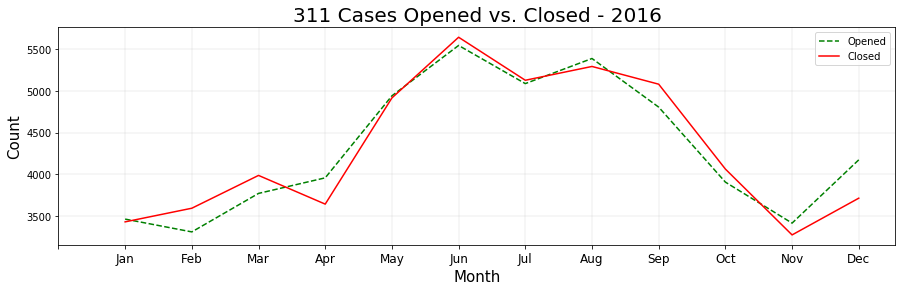

In [46]:
# Time series for 311 Cases Opened vs. Closed - 2016.

df.loc['2016'].groupby('opened_month')['subject'].count().plot(figsize = (15,4), linestyle='dashed',
                                                               color = 'green', label= 'Opened')
df.loc['2016'].groupby('closed_month')['subject'].count().plot(figsize = (15,4), 
                                                               color = 'red', label= 'Closed')
plt.title('311 Cases Opened vs. Closed - 2016', fontsize=20)
plt.ylabel('Count', fontsize = 15)
plt.xlabel('Month', fontsize = 15)
plt.xticks(np.arange(13), months, 
           fontsize='12', horizontalalignment='center')
plt.legend()
plt.grid(linewidth=.2)
plt.show()

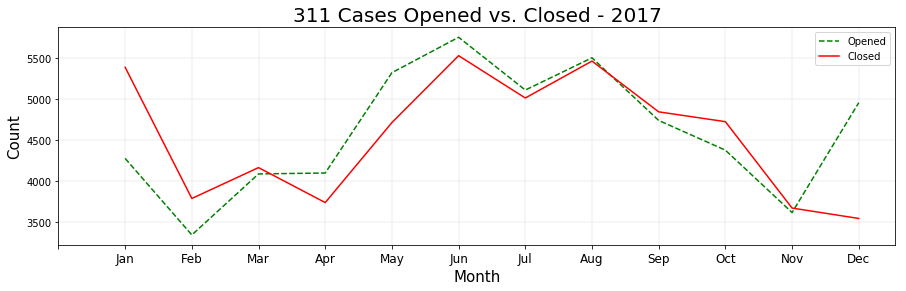

In [47]:
# Time series for 311 Cases Opened vs. Closed - 2017.

df.loc['2017'].groupby('opened_month')['subject'].count().plot(figsize = (15,4), linestyle='dashed', 
                                                               color = 'green', label= 'Opened')
df.loc['2017'].groupby('closed_month')['subject'].count().plot(figsize = (15,4), 
                                                               color = 'red', label= 'Closed')
plt.title('311 Cases Opened vs. Closed - 2017', fontsize=20)
plt.ylabel('Count', fontsize = 15)
plt.xlabel('Month', fontsize = 15)
plt.xticks(np.arange(13), months, 
           fontsize='12', horizontalalignment='center')
plt.legend()
plt.grid(linewidth=.2)
plt.show()

### Busiest months for resolving complaints:
- **May - September or October**: In 2016, the City consistently closed cases at a slightly higher rate than they were opened. This shows good workflow. Performance worsened in 2017, when complaint volume grew slightly. Workload may have impacted close rates, as they **fell behind April through July.**
- **December**: Sidewalk Snow and Ice complaints were difficult to resolve in both years, but more noticably in 2017. We saw this in our search for outliers, with large clusters of these cases closed at the end of winter.

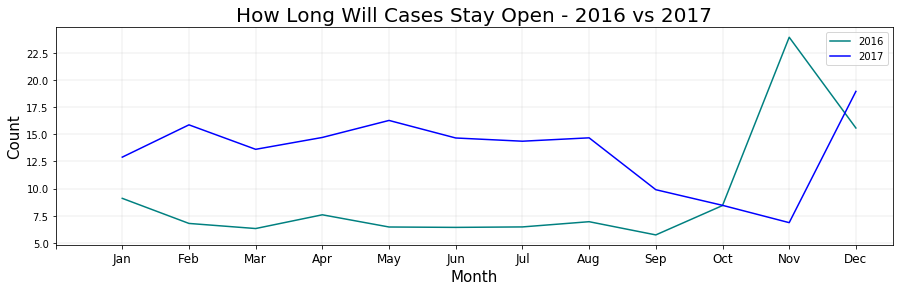

In [48]:
# Case age by opened month - 2016 vs 2017

df.loc['2016'].groupby('opened_month')['days_open'].mean().plot(figsize = (15,4), 
                                                               color = 'teal', label= '2016')
df.loc['2017'].groupby('opened_month')['days_open'].mean().plot(figsize = (15,4), 
                                                               color = 'blue', label= '2017')
plt.title('How Long Will Cases Stay Open - 2016 vs 2017', fontsize=20)
plt.ylabel('Count', fontsize = 15)
plt.xlabel('Month', fontsize = 15)
plt.xticks(np.arange(13), months, 
           fontsize='12', horizontalalignment='center')
plt.legend()
plt.grid(linewidth=.2)
plt.show()

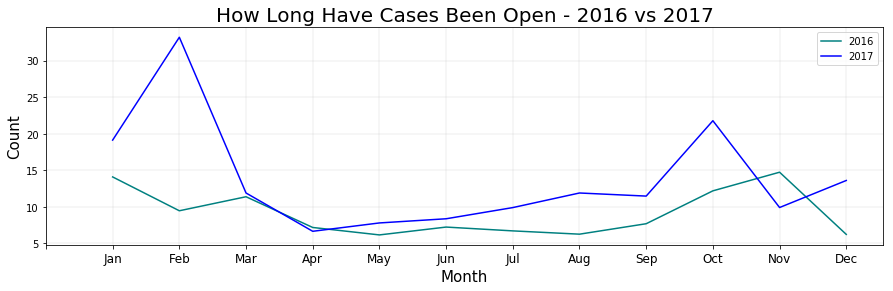

In [49]:
# How long were cases open when finally closed - 2016 vs 2017

df.loc['2016'].groupby('closed_month')['days_open'].mean().plot(figsize = (15,4), 
                                                               color = 'teal', label= '2016')
df.loc['2017'].groupby('closed_month')['days_open'].mean().plot(figsize = (15,4), 
                                                               color = 'blue', label= '2017')
plt.title('How Long Have Cases Been Open - 2016 vs 2017', fontsize=20)
plt.ylabel('Count', fontsize = 15)
plt.xlabel('Month', fontsize = 15)
plt.xticks(np.arange(13), months, 
           fontsize='12', horizontalalignment='center')
plt.legend()
plt.grid(linewidth=.2)
plt.show()

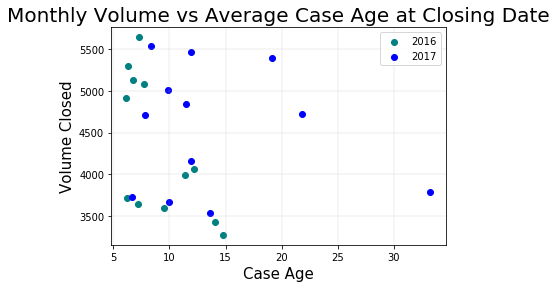

In [50]:
# Scatter plot of number of cases closed in a month vs average case age at close

age_16 = df.loc['2016'].groupby('closed_month')['days_open'].mean()
volume_16 = df.loc['2016'].groupby('closed_month')['title'].count()

age_17 = df.loc['2017'].groupby('closed_month')['days_open'].mean()
volume_17 = df.loc['2017'].groupby('closed_month')['title'].count()

plt.scatter(age_16, volume_16, label= '2016', color = 'teal')
plt.scatter(age_17, volume_17, label= '2017', color = 'blue')
plt.title('Monthly Volume vs Average Case Age at Closing Date', fontsize=20)
plt.xlabel('Case Age', fontsize = 15)
plt.ylabel('Volume Closed', fontsize = 15)
plt.legend()
plt.grid(linewidth=.2)
plt.show()

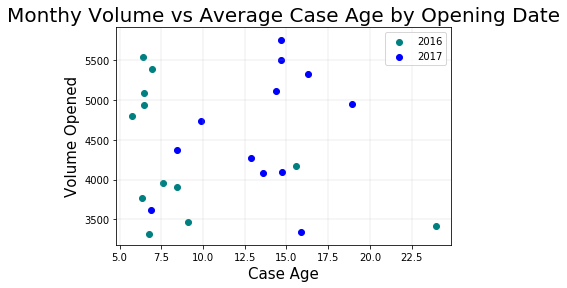

In [51]:
# Scatter plot of number of cases OPENED in a month vs average case age at close

age_16 = df.loc['2016'].groupby('opened_month')['days_open'].mean()
volume_16 = df.loc['2016'].groupby('opened_month')['title'].count()

# Fit with polyfit
b, m = np.polyfit(age_16, volume_16, 1)


age_17 = df.loc['2017'].groupby('opened_month')['days_open'].mean()
volume_17 = df.loc['2017'].groupby('opened_month')['title'].count()
# Fit with polyfit
b2, m2 = np.polyfit(age_17, volume_17, 1)


plt.scatter(age_16, volume_16, label= '2016', color = 'teal')
#plt.plot(age_16, b + m * age_16, '-', color = 'teal')

plt.scatter(age_17, volume_17, label= '2017', color = 'blue')
#plt.plot(age_17, b2 + m2 * age_17, '-', color = 'blue')

plt.title('Monthy Volume vs Average Case Age by Opening Date', fontsize=20)
plt.xlabel('Case Age', fontsize = 15)
plt.ylabel('Volume Opened', fontsize = 15)
plt.legend()
plt.grid(linewidth=.2)
plt.show()

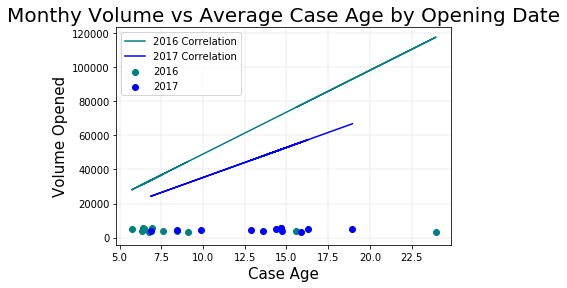

In [52]:

# Not sure why the polyfit lines are so high

plt.scatter(age_16, volume_16, label= '2016', color = 'teal')
plt.plot(age_16, b + m * age_16, '-', label= '2016 Correlation' , color = 'teal')

plt.scatter(age_17, volume_17, label= '2017', color = 'blue')
plt.plot(age_17, b2 + m2 * age_17, '-', label= '2017 Correlation', color = 'blue')

plt.title('Monthy Volume vs Average Case Age by Opening Date', fontsize=20)
plt.xlabel('Case Age', fontsize = 15)
plt.ylabel('Volume Opened', fontsize = 15)
plt.legend()
plt.grid(linewidth=.2)
plt.show()

## Map Data

### Import Neighborhood Shape File
http://opendata.minneapolismn.gov/datasets/neighborhoods
* Neighborhoods.shp

In [53]:
# read in neighborhoods shapefile
hoods = gpd.read_file(r"Neighborhoods/Neighborhoods.shp")
hoods.head(3)

,OBJECTID,INT_REFNO,PREFIX,UDI,SYMBOL_NAM,BDNAME,BDNUM,TEXT_NBR,Shape__Are,Shape__Len,geometry
0,1,-2144139700,REFNO,23103.00,WARDAREA,Victory,3,03,0.000202,0.068721,"POLYGON ((-93.3193815366222 45.042016303131, -..."
1,2,0,REFNO,23108.00,WARDAREA,Humboldt Industrial Area,8,08,0.000081,0.049060,"POLYGON ((-93.3193860506565 45.0421783244357, ..."
2,3,-2144133700,REFNO,23163.00,WARDAREA,Howe,63,63,0.000314,0.082525,"POLYGON ((-93.2010422053324 44.941551562735, -..."


In [54]:
# assign coordinate system projection 
hoods = hoods.to_crs({'init': 'epsg:4326'})

# rename neighborhood column
hoods = hoods.rename(columns = {'BDNAME' : 'hood'})

hoods.head(3)

,OBJECTID,INT_REFNO,PREFIX,UDI,SYMBOL_NAM,hood,BDNUM,TEXT_NBR,Shape__Are,Shape__Len,geometry
0,1,-2144139700,REFNO,23103.00,WARDAREA,Victory,3,03,0.000202,0.068721,"POLYGON ((-93.3193815366222 45.042016303131, -..."
1,2,0,REFNO,23108.00,WARDAREA,Humboldt Industrial Area,8,08,0.000081,0.049060,"POLYGON ((-93.3193860506565 45.0421783244357, ..."
2,3,-2144133700,REFNO,23163.00,WARDAREA,Howe,63,63,0.000314,0.082525,"POLYGON ((-93.2010422053324 44.941551562735, -..."


In [55]:
# Prepare 311 data to be used for mapping

def make_point(row):
    return Point(row.x_geom, row.y_geom)

# Exclude rows that don't have longitude and latitude
# This removes 7,986 rows (or 8.07 %) and leaves 98,942 to work with
df_with_geom = df[df['x_geom'] < 0]

# Go through every row, and make a point out of its lat and lon
points = df_with_geom.apply(make_point, axis=1)

# Make a new GeoDataFrame that combines 311 data and the geometry we just made
geo_311 = gpd.GeoDataFrame(df_with_geom, geometry=points)

# Designate the CRS (coordinate reference system) to be the standard shape of the earth
geo_311.crs = {'init': 'epsg:4326'}

# Let's look at the first few
geo_311.head(2)

status         closed_date  days_open           reason  \
Date       Time                                                               
2016-01-01 00:10:35       0 2016-01-02 12:03:41        2.0  Traffic Control   
           07:50:34       0 2016-01-02 09:08:54        2.0  Traffic Control   

                                    subject                        title  \
Date       Time                                                            
2016-01-01 00:10:35  Vehicles and Commuting  Abandoned Vehicle - Open311   
           07:50:34  Vehicles and Commuting  Parking Violation - Open311   

                     object_id       x_coord       y_coord     x_geom  \
Date       Time                                                         
2016-01-01 00:10:35       2196 -1.038160e+07  5.613667e+06 -93.259481   
           07:50:34      29550 -1.038520e+07  5.616158e+06 -93.291802   

                                         ...                        open_day  \
Date       Time                          ...                                   
2016-01-01 00:10:35                      ...                      2016-01-01   
           07:50:34                      ...                      2016-01-01   

                     open_time  closed_year closed_month max_temp  min_temp  \
Date       Time                                                               
2016-01-01 00:10:35   00:10:35       2016.0          1.0       30        15   
           07:50:34   07:50:34       2016.0          1.0       30        15   

                     precipitation   snow  snow_depth  \
Date       Time                                         
2016-01-01 00:10:35          0.005  0.005         4.0   
           07:50:34          0.005  0.005         4.0   

                                                         geometry  
Date       Time                                                    
2016-01-01 00:10:35  POINT (-93.25948128957221 44.95008652484643)  
           07:50:34  POINT (-93.29180214798036 44.96591844428954)  

[2 rows x 23 columns]

In [56]:
# Gather geometry data for Abandoned Vehicle complaints, limit it to 2016
abandoned_vehicles = geo_311[(geo_311.opened_year == 2016) & (geo_311.title.str.contains('Abandoned Vehicle'))]
abandoned_vehicles_geo = abandoned_vehicles[['y_geom', 'x_geom']]

# List comprehension to make out list of lists
heat_data = [[row['y_geom'],row['x_geom']] for index, row in abandoned_vehicles_geo.iterrows()]
heat_data[:3]

# Even limiting this data to 2016, creates a map that's almost entirely red.

[[44.95008652484643, -93.25948128957221],
 [45.01313984807025, -93.29171219517937],
 [44.892501084201754, -93.26974521812464]]

In [57]:
#hoarding = geo_311[(geo_311.opened_year == 2016) & (geo_311.title.str.contains('Hoarding'))]
hoarding = geo_311[geo_311.title.str.contains('Hoarding')]
hoarding_geo = hoarding[['y_geom', 'x_geom']]

# List comprehension to make out list of lists
heat_data = [[row['y_geom'],row['x_geom']] for index, row in hoarding_geo.iterrows()]

In [58]:
# Heat map with neighborhood borders.
some_coords = [44.986656, -93.258133]
map_ = folium.Map(location=some_coords, zoom_start=12)
#folium.Marker(location = [-93.25948128957221, 44.95008652484643], icon=folium.Icon(icon='star')).add_to(map_)
folium.GeoJson(hoods,
    style_function=lambda feature: {
        'fill color' : 'blue',
        'color' : 'teal',
        'weight' : 1.5,
        'fillOpacity' : 0.0,
        }
    ).add_to(map_)


# Plot it on the map
plugins.HeatMap(heat_data).add_to(map_)
map_

In [59]:
geo_311[geo_311.title.str.contains('Abandoned Vehicle')].title.value_counts()

Abandoned Vehicle              14585
Abandoned Vehicle - Open311     2003
Name: title, dtype: int64

### Join neighborhood and 311 data based on spatial geometry

In [60]:
# remove multi index to allow spatial join
geo = geo_311.reset_index() 

# Geopandas spacial join to find which which neighborhood each 'point' is in
geo_311_hoods = gpd.sjoin(geo, hoods, op='within')

# Set multi Index again
geo_311_hoods.set_index(['Date', 'Time'], inplace=True)

# Remove extra neighborhood related columns, keep "hood" as identifier
geo_311_hoods = geo_311_hoods[['status', 'closed_date', 'days_open', 'reason', 'subject', 'title',
       'object_id', 'x_coord', 'y_coord', 'x_geom', 'y_geom', 'opened_year',
       'opened_month', 'open_day', 'open_time', 'closed_year', 'closed_month',
       'max_temp', 'min_temp', 'precipitation', 'snow', 'snow_depth',
       'geometry', 'hood']]

geo_311_hoods.head(2)

,,status,closed_date,days_open,reason,subject,title,object_id,x_coord,y_coord,x_geom,...,open_time,closed_year,closed_month,max_temp,min_temp,precipitation,snow,snow_depth,geometry,hood
Date,Time,,,,,,,,,,,,,,,,,,,,,
2016-01-01,00:10:35,0,2016-01-02 12:03:41,2.0,Traffic Control,Vehicles and Commuting,Abandoned Vehicle - Open311,2196,-1.038160e+07,5.613667e+06,-93.259481,...,00:10:35,2016.0,1.0,30,15,0.005,0.005,4.0,POINT (-93.25948128957221 44.95008652484643),Midtown Phillips
2016-01-02,10:50:37,0,2016-01-06 21:27:57,5.0,Traffic Control,Vehicles and Commuting,Abandoned Vehicle - Open311,2204,-1.038159e+07,5.614523e+06,-93.259425,...,10:50:37,2016.0,1.0,31,14,0.000,0.000,4.0,POINT (-93.25942461845415 44.95553023719341),Midtown Phillips


### Chi Square test for relationship between complaint type and neighborhood

Examining the most general (subject) and specific (title) levels of complaint types, we find a very high chi square test statistic. This means there is not a relationship between neighborhood and 311 call types.

In [61]:
# Tablulate Subject and Hoods columns
subj_hood = pd.crosstab(index=geo_311_hoods['subject'],columns=geo_311_hoods['hood'])
subj_hood.head()

hood,Armatage,Audubon Park,Bancroft,Beltrami,Bottineau,Bryant,Bryn - Mawr,CARAG,Camden Industrial,Cedar - Isles - Dean,...,Ventura Village,Victory,Waite Park,Webber - Camden,Wenonah,West Calhoun,Whittier,Willard - Hay,Windom,Windom Park
subject,,,,,,,,,,,,,,,,,,,,,
Animal Related,121,164,90,42,44,100,108,86,3,56,...,88,207,160,258,101,14,154,339,111,136
Health / Environmental,32,40,33,11,25,23,12,40,0,36,...,47,39,40,38,15,14,140,28,30,30
Permits / Licensing,5,6,10,3,5,1,7,14,1,5,...,12,12,0,16,1,0,45,17,5,2
Property,126,207,165,71,61,109,88,148,0,50,...,114,315,207,445,138,13,258,541,121,175
Public Safety,23,43,42,84,126,118,35,152,7,24,...,98,34,15,85,29,1,562,44,37,67


In [62]:
# Test relationship between complaint title and neighborhood.
subj_chisq = stats.chi2_contingency(subj_hood)

# Printed: (chi square test statistic, p, degrees of freedom)
# Not shown: The expected frequencies, based on the marginal sums of the table
subj_chisq[:3]

(22918.230583855315, 0.0, 774)

In [63]:
# Tablulate Title and Hoods columns
title_hood = pd.crosstab(index=geo_311_hoods['title'],columns=geo_311_hoods['hood'])

# Test relationship between complaint title and neighborhood.
title_chisq = stats.chi2_contingency(title_hood)

# Printed: (chi square test statistic, p, degrees of freedom)
# Not shown: The expected frequencies, based on the marginal sums of the table
title_chisq[:3] 

(84270.47994740201, 0.0, 7826)